## An exploration of wide ranging effects of wildfires on AQI index and population's health 

In [67]:
import math
import geopandas as gpd
import pandas as pd
from shapely.geometry import MultiPolygon
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

import folium
from folium import Choropleth, Marker
from folium.plugins import HeatMap, MarkerCluster
print("Setup Complete")

Setup Complete


### Section 1: Exploring the California 5 year fire dataset

In [68]:
cal_fire_data = gpd.read_file("/DATASETS/CLIMATE_DATASETS/FIRE_DATASET/California_Fire_Perimeters_(Recent).shp")
cal_fire_data.head()

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,SHAPEAREA,SHAPELEN,geometry
0,21462,2020,CA,CDF,CZU,CZU LIGHTNING COMPLEX,00005205,2020-08-16,2020-09-24,1,None,86509.0,86553.460938,7,1,None,5.523185e+08,255052.193260,"MULTIPOLYGON (((-13594665.665 4447773.307, -13..."
1,21480,2020,CA,CDF,ORC,SILVERADO,20121364,2020-10-26,2020-11-02,14,None,0.0,12469.200195,7,1,None,7.312598e+07,65362.593575,"POLYGON ((-13103802.000 3995244.000, -13103693..."
2,21481,2020,CA,CDF,ORC,BLUE RIDGE,20121612,2020-10-26,2020-11-02,14,None,0.0,13694.530273,7,1,None,8.067187e+07,65838.875384,"POLYGON ((-13106401.000 4020965.000, -13106362..."
3,21482,2020,CA,CDF,ORC,BOND,20136890,2020-12-03,2020-12-07,14,None,0.0,6681.101074,7,1,None,3.920048e+07,52771.365477,"POLYGON ((-13095398.000 3994547.000, -13095325..."
4,21515,2020,CA,CCO,KRN,STAGECOACH,02033315,2020-08-03,2020-08-03,14,None,7750.0,7750.637207,1,1,None,4.737386e+07,46920.338200,"POLYGON ((-13188248.679 4224512.550, -13188385..."


In [69]:
use_cols = ['UNIT_ID', 'FIRE_NAME', 'ALARM_DATE', 'CONT_DATE', 'GIS_ACRES', 'geometry']
cal_fire_data = cal_fire_data[use_cols]
cal_fire_data.head()

,UNIT_ID,FIRE_NAME,ALARM_DATE,CONT_DATE,GIS_ACRES,geometry
0,CZU,CZU LIGHTNING COMPLEX,2020-08-16,2020-09-24,86553.460938,"MULTIPOLYGON (((-13594665.665 4447773.307, -13..."
1,ORC,SILVERADO,2020-10-26,2020-11-02,12469.200195,"POLYGON ((-13103802.000 3995244.000, -13103693..."
2,ORC,BLUE RIDGE,2020-10-26,2020-11-02,13694.530273,"POLYGON ((-13106401.000 4020965.000, -13106362..."
3,ORC,BOND,2020-12-03,2020-12-07,6681.101074,"POLYGON ((-13095398.000 3994547.000, -13095325..."
4,KRN,STAGECOACH,2020-08-03,2020-08-03,7750.637207,"POLYGON ((-13188248.679 4224512.550, -13188385..."


In [70]:
cal_fire_data.GIS_ACRES.describe()

count    1.290000e+02
mean     5.816780e+04
std      1.161609e+05
min      5.062198e+03
25%      8.822024e+03
50%      2.131793e+04
75%      5.162466e+04
max      1.032699e+06
Name: GIS_ACRES, dtype: float64

In [75]:
cal_fire_data.dtypes


UNIT_ID               object
FIRE_NAME             object
ALARM_DATE    datetime64[ns]
CONT_DATE     datetime64[ns]
GIS_ACRES            float64
geometry            geometry
duration               int64
year                   int64
month                  int64
dtype: object

In [72]:
# Change the dtype of Alarm date and cont_date
cal_fire_data['ALARM_DATE'] = pd.to_datetime(cal_fire_data['ALARM_DATE'])
cal_fire_data['CONT_DATE'] = pd.to_datetime(cal_fire_data['CONT_DATE'])
cal_fire_data['duration'] = cal_fire_data['CONT_DATE'].dt.to_period('D').astype(int) \
                            - cal_fire_data['ALARM_DATE'].dt.to_period('D').astype(int)
cal_fire_data = cal_fire_data.dropna()
cal_fire_data.dtypes

UNIT_ID               object
FIRE_NAME             object
ALARM_DATE    datetime64[ns]
CONT_DATE     datetime64[ns]
GIS_ACRES            float64
geometry            geometry
duration               int64
dtype: object

In [73]:
# Compute the year column
cal_fire_data['year'] = cal_fire_data['ALARM_DATE'].dt.year
cal_fire_data = cal_fire_data.sort_values('ALARM_DATE', ascending=True)
cal_fire_data['month'] = cal_fire_data['ALARM_DATE'].dt.month
#cal_fire_data['month'] = cal_fire_data['month'].astype(int)

In [74]:
cal_fire_data

,UNIT_ID,FIRE_NAME,ALARM_DATE,CONT_DATE,GIS_ACRES,geometry,duration,year,month
55,LPF,SHERPA,2016-06-15,2016-07-11,7465.751465,"POLYGON ((-13363262.418 4092431.378, -13363256...",26,2016,6
42,MVU,BORDER 3,2016-06-19,2016-07-07,7606.026367,"POLYGON ((-12970017.478 3847689.292, -12970023...",18,2016,6
48,CND,ERSKINE,2016-06-23,2016-06-30,48008.351562,"POLYGON ((-13172105.402 4240567.780, -13172129...",7,2016,6
51,ENF,TRAILHEAD,2016-06-28,2016-11-08,5644.680176,"POLYGON ((-13454936.939 4715077.788, -13454936...",133,2016,6
54,ANF,SAND,2016-07-22,2016-08-07,41382.859375,"MULTIPOLYGON (((-13165545.608 4089924.627, -13...",16,2016,7
...,...,...,...,...,...,...,...,...,...
35,CCD,BACCARAT,2020-10-04,2020-10-11,10456.363281,"MULTIPOLYGON (((-13354640.259 4826534.418, -13...",7,2020,10
2,ORC,BLUE RIDGE,2020-10-26,2020-11-02,13694.530273,"POLYGON ((-13106401.000 4020965.000, -13106362...",7,2020,10
1,ORC,SILVERADO,2020-10-26,2020-11-02,12469.200195,"POLYGON ((-13103802.000 3995244.000, -13103693...",7,2020,10
36,CND,MOUNTAIN VIEW,2020-11-17,2020-11-30,20374.488281,"POLYGON ((-13296874.178 4651985.955, -13297108...",13,2020,11


In [76]:
fig = px.scatter(cal_fire_data, x = 'ALARM_DATE', y = 'GIS_ACRES', size = 'duration',
                 color = 'UNIT_ID', hover_name='FIRE_NAME',
                  size_max=50, title = 'California Wildfires 2016 to 2020')

fig.update_layout(xaxis = dict(showgrid=False), yaxis = dict(showgrid=False))

fig

### Conclusions from the above plot
There are a few conclusions that can be drawn:
1. In the past 5 years, each year there have been fires that burnt for more than 100 days.Trailhead fire in 2016, Schaeffer fire in 2017, Lions in 2017, Springs in 2018 and Rattlesnake in 2020.
2. But what is extraordinary is that number of fires in a year has increased.
3. And the number of acres burnt in the fire have increased, 2020 being the year in which August Complex Fires burnt more than a million acres!

### Section 2: California census and county boundaries

In [91]:
cal_counties = gpd.read_file("/DATASETS/CLIMATE_DATASETS/CA_DEMOGRAPHICS/CA_Counties/CA_Counties_TIGER2016.shp")
cal_counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,None,None,A,2468694587,23299110,+39.5769252,-120.5219926,"POLYGON ((-13431319.751 4821511.426, -13431312..."
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,None,A,2499183617,76073827,+38.4500114,-121.3404409,"POLYGON ((-13490651.476 4680831.603, -13490511..."
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7084000598,2729814515,+34.5370572,-120.0399729,"MULTIPOLYGON (((-13423116.772 4042044.149, -13..."
3,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,None,None,None,A,2641820834,43806026,+38.1838996,-120.5614415,"POLYGON ((-13428575.483 4627725.228, -13428534..."
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4773390489,945942791,+34.3587415,-119.1331432,"MULTIPOLYGON (((-13317853.594 3931602.414, -13..."


In [92]:
cal_counties_cols = ['NAMELSAD', 'geometry']
cal_counties = cal_counties[cal_counties_cols]
cal_counties = cal_counties.rename(columns = {'NAMELSAD': 'County'})
print(cal_counties.dtypes)
cal_counties.head()

County        object
geometry    geometry
dtype: object


,County,geometry
0,Sierra County,"POLYGON ((-13431319.751 4821511.426, -13431312..."
1,Sacramento County,"POLYGON ((-13490651.476 4680831.603, -13490511..."
2,Santa Barbara County,"MULTIPOLYGON (((-13423116.772 4042044.149, -13..."
3,Calaveras County,"POLYGON ((-13428575.483 4627725.228, -13428534..."
4,Ventura County,"MULTIPOLYGON (((-13317853.594 3931602.414, -13..."


In [93]:
cal_pop = pd.read_csv("/DATASETS/CLIMATE_DATASETS/CA_DEMOGRAPHICS/ca_demographics.csv", 
                        usecols=['County', 'Population'], index_col='County')
print(cal_pop.dtypes)
cal_pop.head()

Population    int64
dtype: object


,Population
County,
Los Angeles County,10040682
San Diego County,3323970
Orange County,3170345
Riverside County,2437864
San Bernardino County,2162532


In [48]:
latest_fire_data =  cal_fire_data.loc[cal_fire_data.year>=2020].copy()
latest_fire_data

,UNIT_ID,FIRE_NAME,ALARM_DATE,CONT_DATE,GIS_ACRES,geometry,year,month,duration
6,AEU,GRANT FIRE,2020-06-12,2020-06-12,5.062198e+03,"POLYGON ((-13490462.000 4655244.000, -13490478...",2020,6,0
11,SCU,CREWS,2020-07-05,2020-07-15,5.513000e+03,"POLYGON ((-13519091.900 4438860.494, -13519102...",2020,7,10
7,FKU,MINERAL,2020-07-13,2020-07-26,2.966696e+04,"POLYGON ((-13425044.636 4325786.972, -13425099...",2020,7,13
29,LMU,HOG,2020-07-18,2020-08-28,9.566355e+03,"MULTIPOLYGON (((-13445698.136 4929615.517, -13...",2020,7,41
41,LMU,GOLD,2020-07-20,2020-10-29,2.265256e+04,"MULTIPOLYGON (((-13443927.613 5030372.059, -13...",2020,7,101
32,BNP,CALDWELL,2020-07-22,2020-09-01,8.122437e+04,"POLYGON ((-13536959.355 5136449.174, -13536953...",2020,7,41
31,YNP,BLUEJAY,2020-07-25,2020-11-19,6.921987e+03,"MULTIPOLYGON (((-13311760.228 4561838.821, -13...",2020,7,117
30,SRF,RED SALMON COMPLEX,2020-07-27,2020-11-19,1.438363e+05,"MULTIPOLYGON (((-13724176.440 5013954.702, -13...",2020,7,115
37,CDD,NADEAU,2020-07-29,2020-08-04,9.150368e+03,"POLYGON ((-13072546.662 4299994.559, -13072399...",2020,7,6
12,RRU,APPLE,2020-07-31,2020-08-09,3.320931e+04,"POLYGON ((-12998908.799 4032128.631, -12998870...",2020,7,9


<AxesSubplot:>

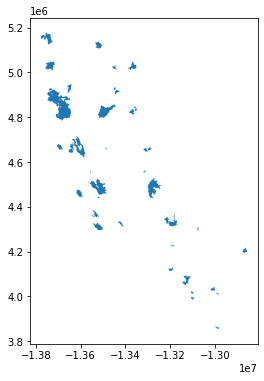

In [49]:
latest_fire_data.plot(figsize=(8,6))

In [79]:
print("CRS:", latest_fire_data.crs)

CRS: epsg:3857


In [50]:
# Use WGS 84 (epsg:4326) as the geographic coordinate system
latest_fire_data = latest_fire_data.to_crs(epsg=4326)
latest_fire_data.head()

,UNIT_ID,FIRE_NAME,ALARM_DATE,CONT_DATE,GIS_ACRES,geometry,year,month,duration
6,AEU,GRANT FIRE,2020-06-12,2020-06-12,5062.198242,"POLYGON ((-121.18688 38.53474, -121.18703 38.5...",2020,6,0
11,SCU,CREWS,2020-07-05,2020-07-15,5513.000000,"POLYGON ((-121.44407 36.99823, -121.44416 36.9...",2020,7,10
7,FKU,MINERAL,2020-07-13,2020-07-26,29666.960938,"POLYGON ((-120.59923 36.18268, -120.59972 36.1...",2020,7,13
29,LMU,HOG,2020-07-18,2020-08-28,9566.355469,"MULTIPOLYGON (((-120.78476 40.43676, -120.7857...",2020,7,41
41,LMU,GOLD,2020-07-20,2020-10-29,22652.558594,"MULTIPOLYGON (((-120.76886 41.12213, -120.7686...",2020,7,101


In [81]:
ca_fires_2020 = latest_fire_data[['FIRE_NAME', 'geometry']].set_index('FIRE_NAME')
ca_fires_2020.head()

,geometry
FIRE_NAME,
CZU LIGHTNING COMPLEX,"MULTIPOLYGON (((-122.12296 37.06215, -122.1233..."
SILVERADO,"POLYGON ((-117.71346 33.74971, -117.71248 33.7..."
BLUE RIDGE,"POLYGON ((-117.73680 33.94161, -117.73645 33.9..."
BOND,"POLYGON ((-117.63796 33.74451, -117.63731 33.7..."
STAGECOACH,"POLYGON ((-118.47205 35.44494, -118.47329 35.4..."


### Section 2 of the notebook
Getting the AQI data for the year 2020

In [56]:
aqi_df = pd.read_csv("./daily_aqi_by_county_2020.csv")
aqi_df = aqi_df.loc[aqi_df["State Name"]=="California"]
aqi_df

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
14197,California,Alameda,6,1,2020-01-01,53,Moderate,PM2.5,06-001-0009,7
14198,California,Alameda,6,1,2020-01-02,43,Good,PM2.5,06-001-0013,7
14199,California,Alameda,6,1,2020-01-03,74,Moderate,PM2.5,06-001-0013,7
14200,California,Alameda,6,1,2020-01-04,45,Good,PM2.5,06-001-0007,7
14201,California,Alameda,6,1,2020-01-05,33,Good,PM2.5,06-001-0007,7
...,...,...,...,...,...,...,...,...,...,...
33445,California,Yolo,6,113,2020-12-27,20,Good,Ozone,06-113-0004,2
33446,California,Yolo,6,113,2020-12-28,33,Good,Ozone,06-113-0004,2
33447,California,Yolo,6,113,2020-12-29,28,Good,Ozone,06-113-0004,3
33448,California,Yolo,6,113,2020-12-30,39,Good,PM2.5,06-113-0004,2


In [64]:
aqi_df["AQI"].value_counts()

31      640
44      621
35      598
38      585
36      569
       ... 
564       1
1851      1
1928      1
339       1
217       1
Name: AQI, Length: 306, dtype: int64